Подключаем библиотеки и файлы и делаем разведочный анализ данных

Выполняем EDA


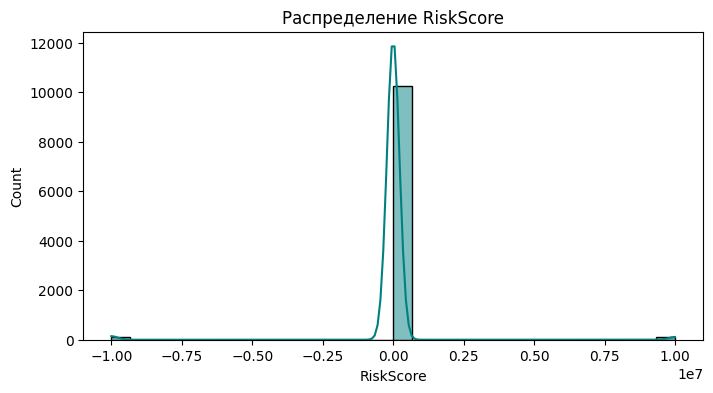

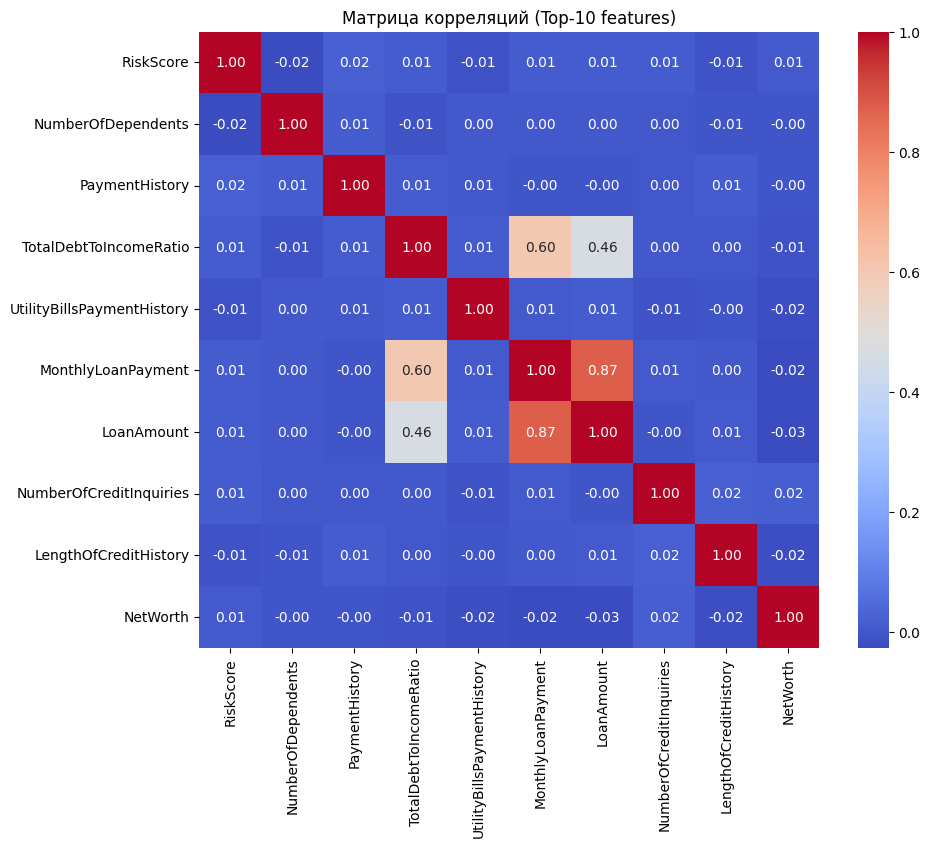

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, LinearRegression as SkLinearRegression
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
SEED = 42

TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
OUT_FILE = "submission_optimized.csv"

train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE) if os.path.exists(TEST_FILE) else None

print("Выполняем EDA")

# 1. График целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(train_df['RiskScore'], bins=30, kde=True, color='teal')
plt.title('Распределение RiskScore')
plt.show()

# 2. Матрица корреляций
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()

# Возьмем топ-10 признаков, коррелирующих с таргетом
top_cols = corr_matrix['RiskScore'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций (Top-10 features)')
plt.show()



Понятно, что данные надо почистить сначала, поэтому выводы чуть позже

Метрики, нормализация, кросс-валидация и класс линейной регрессии

In [3]:
# РУЧНЫЕ МЕТРИКИ
def manual_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def manual_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def manual_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def manual_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

# РУЧНАЯ НОРМАЛИЗАЦИЯ
class ManualStandardScaler:
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self
    def transform(self, X):
        return (X - self.mean_) / (self.std_ + 1e-8)

class ManualMinMaxScaler:
    def fit(self, X):
        self.min_ = np.min(X, axis=0)
        self.max_ = np.max(X, axis=0)
        return self
    def transform(self, X):
        return (X - self.min_) / (self.max_ - self.min_ + 1e-8)

# РУЧНАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ
class ManualLinearRegression:
    def __init__(self, method='analytical', lr=0.001, n_iter=500):
        self.method = method
        self.lr = lr
        self.n_iter = n_iter
        self.w = None
        self.b = None
        self.costs = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.w = np.zeros(n_features)
        self.b = 0

        if self.method == 'analytical':

            X_b = np.c_[np.ones((n_samples, 1)), X]
            try:
                theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
                self.b = theta[0]
                self.w = theta[1:]
            except np.linalg.LinAlgError:
                print("Матрица вырождена, использую псевдообратную")

        elif self.method in ['gd', 'sgd']:
            for i in range(self.n_iter):
                if self.method == 'gd':
                    # Полный градиент
                    y_pred = X.dot(self.w) + self.b
                    dw = (2/n_samples) * X.T.dot(y_pred - y)
                    db = (2/n_samples) * np.sum(y_pred - y)
                else:
                    # Стохастический
                    idx = np.random.randint(0, n_samples)
                    X_i = X[idx].reshape(1, -1)
                    y_i = y[idx]
                    y_pred = X_i.dot(self.w) + self.b
                    dw = 2 * X_i.T.dot(y_pred - y_i).flatten()
                    db = 2 * (y_pred - y_i)

                self.w -= self.lr * dw
                self.b -= self.lr * db

                if i % 100 == 0 and self.method == 'gd':
                     cost = np.mean((y - (X.dot(self.w) + self.b))**2)
                     self.costs.append(cost)
        return self

    def predict(self, X):
        return np.dot(X, self.w) + self.b

# РУЧНАЯ КРОСС-ВАЛИДАЦИЯ
def manual_cross_val_score(model, X, y, cv=5):
    X = np.array(X)
    y = np.array(y)
    n = len(X)
    fold_size = n // cv
    scores = []

    indices = np.arange(n)

    for i in range(cv):
        idx_val = indices[i*fold_size : (i+1)*fold_size]
        idx_train = np.setdiff1d(indices, idx_val)

        X_tr_f, X_val_f = X[idx_train], X[idx_val]
        y_tr_f, y_val_f = y[idx_train], y[idx_val]

        model.fit(X_tr_f, y_tr_f)
        p = model.predict(X_val_f)
        scores.append(manual_mse(y_val_f, p))

    return np.mean(scores)

Добавим вспомогательные функции, почистим данные

In [4]:

def safe_log_plus_one(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    if s.isnull().all(): return s
    mn = s.min(skipna=True)
    if pd.notna(mn) and mn < 0: s = s + abs(mn) + 1
    return np.log1p(s.fillna(0))

def cleanup_data(df: pd.DataFrame, train_mode=True):
    df = df.copy()
    # Убираем совсем кривые таргеты
    if train_mode and "RiskScore" in df:
        df = df[df["RiskScore"].between(0.1, 99.9)]

    # Даты
    if "ApplicationDate" in df:
        dt = pd.to_datetime(df["ApplicationDate"], errors="coerce")
        df["App_Year"] = dt.dt.year.fillna(0)

    eps = 1e-6
    # Отношения
    if "MonthlyLoanPayment" in df and "MonthlyIncome" in df:
        df["PayToInc"] = df["MonthlyLoanPayment"] / (df["MonthlyIncome"] + eps)
    if "TotalLiabilities" in df and "TotalAssets" in df:
        df["DebtToAssets"] = df["TotalLiabilities"] / (df["TotalAssets"] + eps)
    if "LoanAmount" in df and "AnnualIncome" in df:
        df["LoanToInc"] = df["LoanAmount"] / (df["AnnualIncome"] + eps)

    # 3. Взаимодействия
    if "CreditScore" in df and "AnnualIncome" in df:
         df["Score_x_Income"] = df["CreditScore"] * df["AnnualIncome"]

    # 4. Log transform
    log_cols = ["MonthlyIncome", "LoanAmount", "TotalAssets", "TotalLiabilities", "SavingsAccountBalance"]
    for c in log_cols:
        if c in df: df[c] = safe_log_plus_one(df[c])

    # 5. Клиппинг (срезаем 1% самых диких выбросов)
    num_cols = df.select_dtypes(include=np.number).columns
    for c in num_cols:
        if c != "RiskScore":
            lo, hi = df[c].quantile([0.01, 0.99])
            df[c] = df[c].clip(lo, hi)

    return df

print("Чистим данные")
train_clean = cleanup_data(train_df, True)
test_clean = cleanup_data(test_df, False) if test_df is not None else None

target = "RiskScore"
all_features = [c for c in train_clean.columns if c not in [target, "ID", "ApplicationDate"]]

bin_cols = [c for c in ["Age", "CreditScore", "JobTenure"] if c in train_clean.columns]

nums = [c for c in train_clean[all_features].select_dtypes(include=np.number).columns if c not in bin_cols]
cats = train_clean[all_features].select_dtypes(exclude=np.number).columns.tolist()

X = train_clean[all_features]
y = train_clean[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"Данные готовы. Train: {X_train.shape}")

Чистим данные
Данные готовы. Train: (8217, 38)


Сделаем ещё вывод графиков на очищенных данных

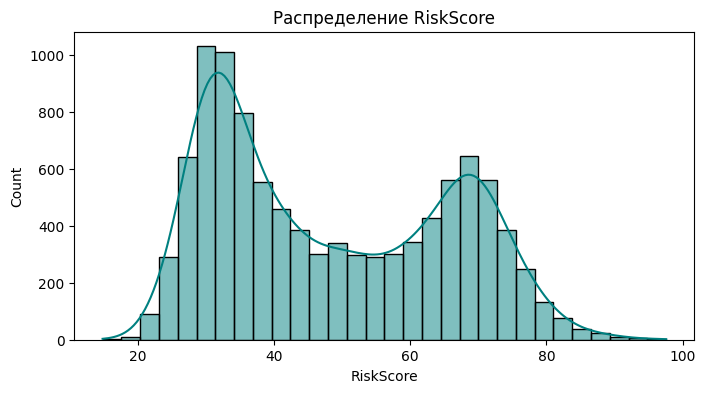

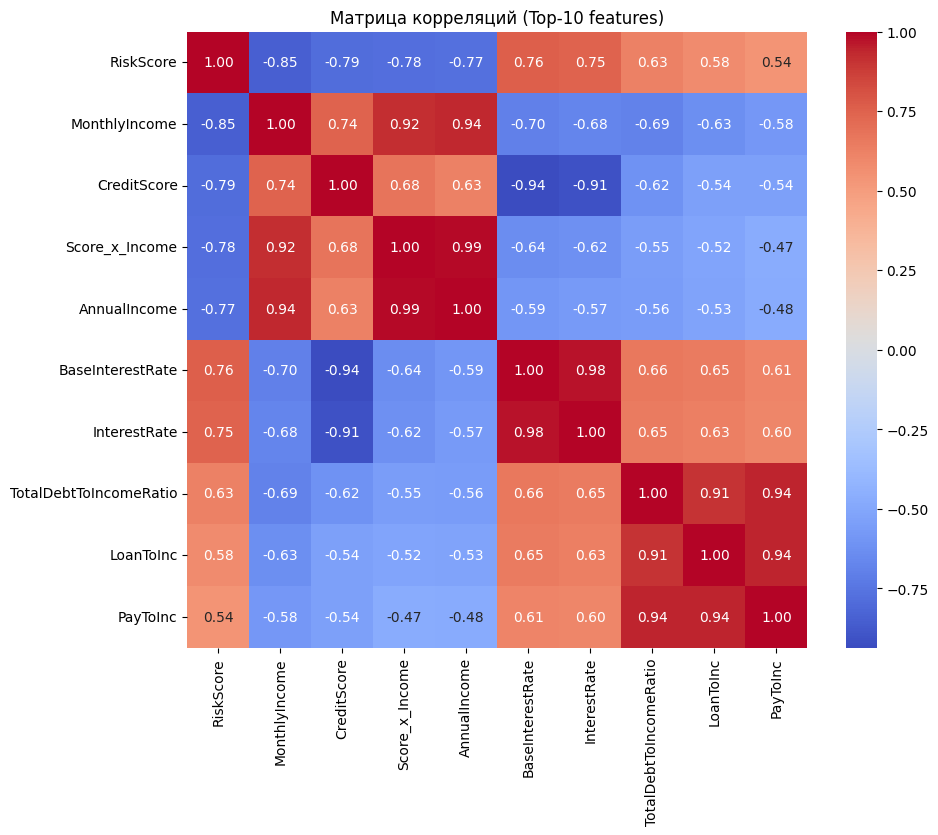

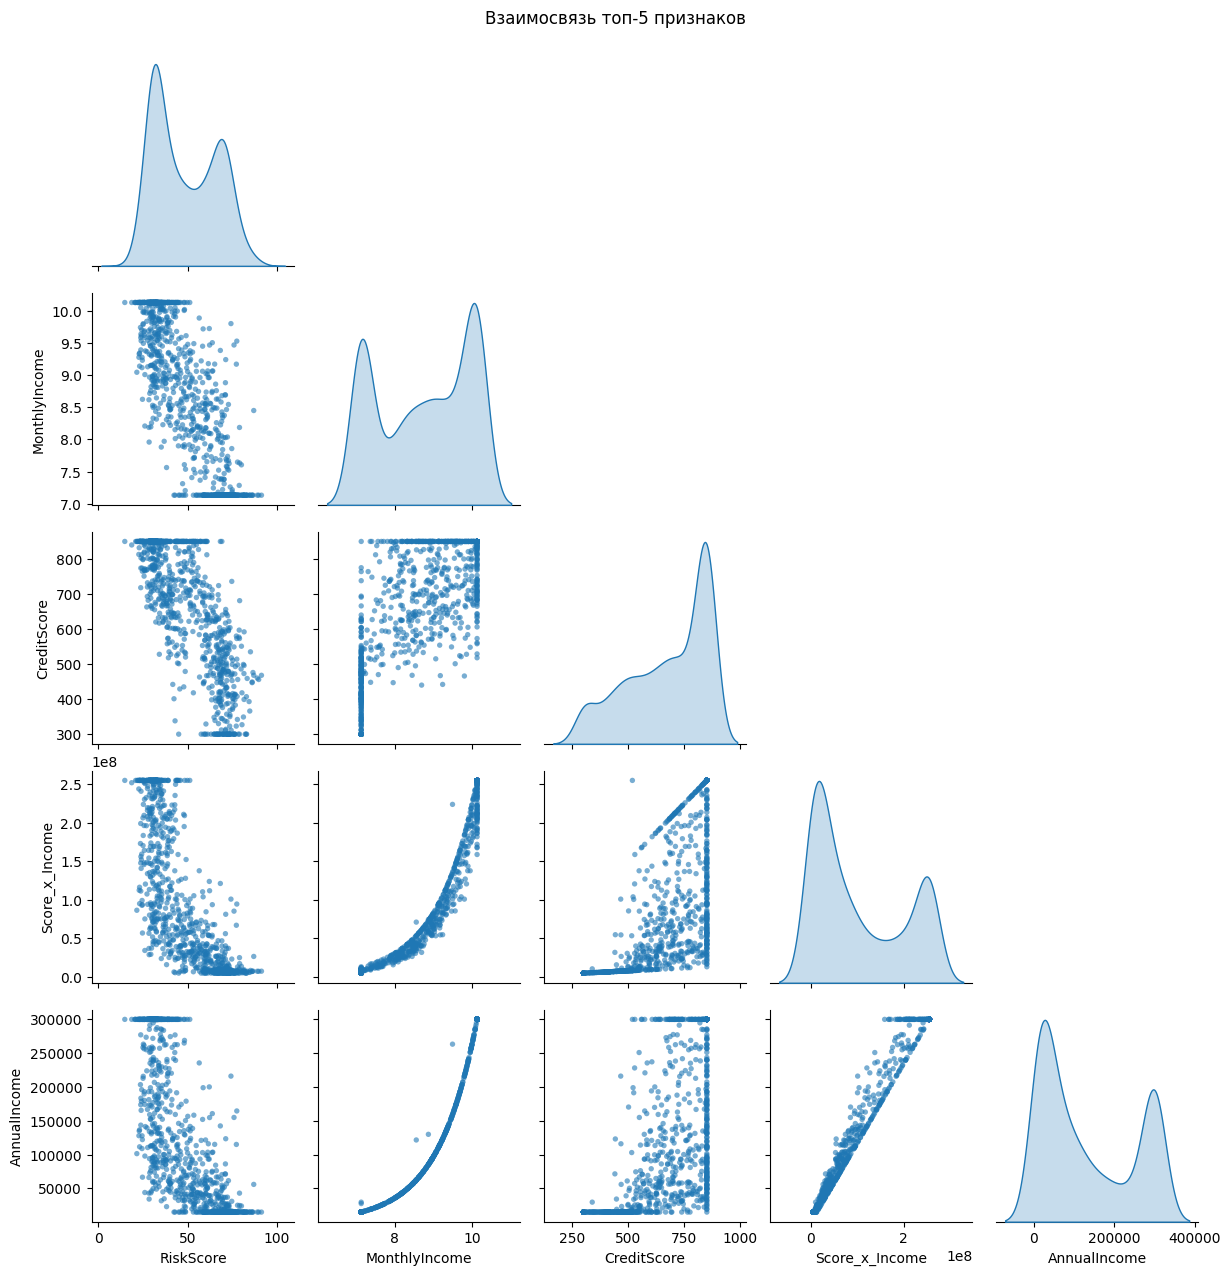

In [5]:
# 1. График целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(train_clean['RiskScore'], bins=30, kde=True, color='teal')
plt.title('Распределение RiskScore')
plt.show()

# 2. Матрица корреляций
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns
corr_matrix = train_clean[numeric_cols].corr()

# Возьмем топ-10 признаков, коррелирующих с таргетом
top_cols = corr_matrix['RiskScore'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 8))
sns.heatmap(train_clean[top_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций (Top-10 features)')
plt.show()
# 3. Pairplot
cols_to_plot = top_cols[:5]

# Берем случайные 1000 строк, чтобы график был чистым и строился быстро
# Если данных меньше 1000, берем все
sample_size = min(1000, len(train_clean))
plot_data = train_clean[cols_to_plot].sample(n=sample_size, random_state=42)

# Строим график
sns.pairplot(
    plot_data,
    diag_kind='kde',       # Красивые "горки" распределения на диагонали
    corner=True,           # Оставляем только нижний угол (чтобы не дублировать)
    plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'none'} # Настройка прозрачности точек
)

plt.suptitle("Взаимосвязь топ-5 признаков", y=1.02) # Заголовок чуть выше
plt.show()

Выводы по графикам
Распределение не является нормальным, что важно учитывать при обучении линейных моделей, значения лежат в интервале от ~15 до ~95.
Наибольшее влияние на целевую переменную оказывают MonthlyIncome (корреляция -0.85) и CreditScore (-0.79). Зависимость обратная: чем выше доход и кредитный рейтинг, тем ниже риск дефолта. Процентные ставки (BaseInterestRate, InterestRate) имеют сильную прямую корреляцию с риском (+0.76).
Поскольку зависимости не являются строгими прямыми линиями, использование полиномиальных признаков (PolynomialFeatures) и биннинга (KBinsDiscretizer) является обоснованным шагом для улучшения качества предсказаний.

Пайплайны

In [6]:
# 1. Числа: Yeo-Johnson
num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('pt', PowerTransformer()),
])

# 2. Категории: OHE
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. БИННИНГ: Разбиваем возраст и скор на 10 групп
bin_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('bins', KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, nums),
    ('cat', cat_pipe, cats),
    ('bin', bin_pipe, bin_cols)
])

# ГЛАВНЫЙ ПАЙПЛАЙН
feature_pipe = Pipeline([
    ('prep', preprocessor),
    ('vt', VarianceThreshold(1e-4)),

    ('k1', SelectKBest(f_regression, k=min(1000, X_train.shape[1]))),

    # Делаем полиномы СТЕПЕНИ 2 (3-я степень давала переобучение)
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),

    ('k2', SelectKBest(f_regression, k=2000))
])

Xt_tr = feature_pipe.fit_transform(X_train, y_train)
Xt_va = feature_pipe.transform(X_val)

Типо обучение

In [7]:
def blended_weight(y_true, pred_a, pred_b):
    d = pred_a - pred_b
    denom = np.dot(d, d)
    if denom == 0: return 0.5
    w = np.dot(d, (y_true - pred_b)) / denom
    return float(np.clip(w, 0, 1))

# Сетка перебора регуляризации
alphas = np.logspace(np.log10(4), np.log10(40), 30)
best_res = {"mse": 1e9, "alpha": None, "w": None}

print(f"\n>>> Поиск гиперпараметров...")
print(f"{'Alpha':<10} | {'Weight':<8} | {'MSE':<10}")
print("-" * 35)

for alpha in alphas:
    try:
        # Обучаем Ridge и обычную Линейную регрессию
        m_ridge = Ridge(alpha=alpha).fit(Xt_tr, y_train)
        m_lr = SkLinearRegression().fit(Xt_tr, y_train)

        # Предсказываем
        p_r = np.clip(m_ridge.predict(Xt_va), 0, 100)
        p_l = np.clip(m_lr.predict(Xt_va), 0, 100)

        # Ищем идеальный вес
        w = blended_weight(y_val, p_l, p_r)

        # Смешиваем: Final = w * LR + (1-w) * Ridge
        final_p = np.clip(w * p_l + (1 - w) * p_r, 0, 100)
        mse = mean_squared_error(y_val, final_p)

        if mse < best_res["mse"]:
            best_res = {"mse": mse, "alpha": alpha, "w": w, "preds": final_p}
            print(f"{alpha:<10.4f} | {w:<8.3f} | {mse:<10.5f} <--- New Best!")

    except Exception as e:
        continue

print("-" * 35)
print(f"ЛУЧШИЙ MSE: {best_res['mse']:.5f}")


>>> Поиск гиперпараметров...
Alpha      | Weight   | MSE       
-----------------------------------
4.0000     | 0.000    | 27.08500   <--- New Best!
4.3305     | 0.000    | 27.07118   <--- New Best!
4.6884     | 0.000    | 27.05782   <--- New Best!
5.0758     | 0.000    | 27.04495   <--- New Best!
5.4953     | 0.000    | 27.03263   <--- New Best!
5.9494     | 0.005    | 27.02087   <--- New Best!
6.4410     | 0.014    | 27.00954   <--- New Best!
6.9733     | 0.023    | 26.99865   <--- New Best!
7.5496     | 0.033    | 26.98823   <--- New Best!
8.1734     | 0.042    | 26.97829   <--- New Best!
8.8489     | 0.051    | 26.96886   <--- New Best!
9.5801     | 0.061    | 26.95998   <--- New Best!
10.3718    | 0.070    | 26.95166   <--- New Best!
11.2289    | 0.079    | 26.94392   <--- New Best!
12.1568    | 0.089    | 26.93678   <--- New Best!
13.1614    | 0.098    | 26.93027   <--- New Best!
14.2490    | 0.108    | 26.92438   <--- New Best!
15.4265    | 0.117    | 26.91914   <--- New Best!

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
#ПРОВЕРКА РУЧНЫХ МЕТРИК
best_preds = best_res["preds"]
print("\nСравнение метрик")
print(f"Sklearn MSE: {best_res['mse']:.5f}")
print(f"Manual  MSE: {manual_mse(y_val, best_preds):.5f}")
print(f"Sklearn MAE: {mean_absolute_error(y_val, best_preds):.5f}")
print(f"Manual  MAE: {manual_mae(y_val, best_preds):.5f}")
print(f"Sklearn R2: {r2_score(y_val, best_preds):.5f}")
print(f"Manual  R2:  {manual_r2(y_val, best_preds):.5f}")
print(f"Sklearn MAPE: {mean_absolute_percentage_error(y_val, best_preds) * 100:.5f}%")
print(f"Manual MAPE: {manual_mape(y_val, best_preds):.5f}%")


# ПРОВЕРКА РУЧНОЙ РЕГРЕССИИ
print("\nОТЧЕТ 2: Тест ручной регрессии")
# Берем маленькую часть данных
X_mini_tr = Xt_tr[:500, :20]
y_mini_tr = y_train[:500]
X_mini_va = Xt_va[:100, :20]
y_mini_va = y_val[:100]

# 1. Аналитическое решение (Manual)
man_ana = ManualLinearRegression(method='analytical')
man_ana.fit(X_mini_tr, y_mini_tr)
p_ana = man_ana.predict(X_mini_va)
print(f"Manual Analytical MSE: {manual_mse(y_mini_va, p_ana):.5f}")

# 2. Градиентный спуск (Manual)
man_gd = ManualLinearRegression(method='gd', lr=0.01, n_iter=500)
man_gd.fit(X_mini_tr, y_mini_tr)
p_gd = man_gd.predict(X_mini_va)
print(f"Manual GD MSE:         {manual_mse(y_mini_va, p_gd):.5f}")


# ПРОВЕРКА КРОСС-ВАЛИДАЦИИ
print("\nТест ручной Кросс-валидации")
cv_score = manual_cross_val_score(SkLinearRegression(), X_mini_tr, y_mini_tr, cv=5)
print(f"Manual CV Score (Mean MSE): {cv_score:.5f}")


#сохраняем файлик
if best_res["mse"] < 35:
    X_full = pd.concat([X_train, X_val])
    y_full = pd.concat([y_train, y_val])

    # Трансформируем полные данные
    Xt_full = feature_pipe.fit_transform(X_full, y_full)
    Xt_test = feature_pipe.transform(test_clean)

    # Обучаем лучшие модели
    fin_ridge = Ridge(alpha=best_res["alpha"]).fit(Xt_full, y_full)
    fin_lr = SkLinearRegression().fit(Xt_full, y_full)

    # Предсказываем
    pr = np.clip(fin_ridge.predict(Xt_test), 0, 100)
    pl = np.clip(fin_lr.predict(Xt_test), 0, 100)

    # Смешиваем
    w = best_res["w"]
    final = np.clip(w * pl + (1 - w) * pr, 0, 100)

    # Сохраняем
    sub = pd.DataFrame({"ID": test_df.get("ID", np.arange(len(final))), "RiskScore": final})
    sub.to_csv(OUT_FILE, index=False)
    print(f"\nФайл {OUT_FILE} успешно сохранен!")

else:
    print(f"ВНИМАНИЕ: MSE ({best_res['mse']:.2f}) слишком высокий. Попробуй изменить параметры пайплайна.")


Сравнение метрик
Sklearn MSE: 26.90076
Manual  MSE: 26.90076
Sklearn MAE: 3.80429
Manual  MAE: 3.80429
Sklearn R2: 0.91005
Manual  R2:  0.91005
Sklearn MAPE: 8.92246%
Manual MAPE: 8.92246%

ОТЧЕТ 2: Тест ручной регрессии
Manual Analytical MSE: 46.00584
Manual GD MSE:         45.11936

Тест ручной Кросс-валидации
Manual CV Score (Mean MSE): 40.95452

Файл submission_optimized.csv успешно сохранен!
